In [1]:
from IPython.core.display import HTML
HTML("\n".join(open('mioti_style.css', 'r').readlines()))

<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Machine Learning</center>

# Worksheet S3: Datos no balanceados y KNN

## Objetivos

Los objetivos de este worksheet son que:

* Manejes datasets no balanceados
* Aprender nuevos esquemas de evaluación
* Conozcas nuevos clasificadores: KNN

## Configuración del entorno

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

También vamos a cargar algunas funciones que nos resultarán interesantes. 

*Nota: De las siguientes funciones de apoyo no hace falta que entiendas el código de la misma. Sólo que hacen no cómo lo hacen.*

In [3]:
def plot_2d_separator(classifier, X, y, fill=False, ax=None, eps=None):
    from matplotlib.colors import ListedColormap
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:,0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
    
    if eps is None:
        eps = X.std() / 2.
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0]
        fill_levels = [decision_values.min(), 0, decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5]
        fill_levels = [0, .5, 1]

    if ax is None:
        ax = plt.gca()

    ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels, colors="black")

In [4]:
def dibuja_dataset(X, y):  
    from matplotlib.colors import ListedColormap
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:,0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')

## Dataset

En este caso vamos a generar un dataset ficticio como el del worksheet anterior. En este caso usaremos la función `make_blobs` para generar conjuntos de puntos `blobs`:

In [160]:
from sklearn.datasets import make_blobs

dataset = make_blobs(random_state=0, centers=2)

In [161]:
dataset_X = dataset[0]
dataset_y = np.copy(dataset[1])

In [162]:
print(dataset_X)

[[ 4.21850347  2.23419161]
 [ 0.90779887  0.45984362]
 [-0.27652528  5.08127768]
 [ 0.08848433  2.32299086]
 [ 3.24329731  1.21460627]
 [ 1.44193252  2.76754364]
 [ 1.0220286   4.11660348]
 [ 3.97820955  2.37817845]
 [ 0.58894326  4.00148458]
 [ 1.25185786  0.20811388]
 [ 0.62835793  4.4601363 ]
 [ 1.68608568  0.65828448]
 [ 1.18454506  5.28042636]
 [ 0.06897171  4.35573272]
 [ 1.78726415  1.70012006]
 [ 4.4384123   1.84214315]
 [ 3.18190344 -0.18226785]
 [ 0.30380963  3.94423417]
 [ 0.73936011  0.43607906]
 [ 1.28535145  1.43691285]
 [ 1.1312175   4.68194985]
 [ 0.66471755  4.35995267]
 [ 1.31570453  2.44067826]
 [-0.18887976  5.20461381]
 [ 2.57854418  0.72611733]
 [ 0.87305123  4.71438583]
 [ 1.3105127   0.07122512]
 [ 0.9867701   6.08965782]
 [ 1.42013331  4.63746165]
 [ 2.3535057   2.22404956]
 [ 2.43169305 -0.20173713]
 [ 1.0427873   4.60625923]
 [ 0.95088418  0.94982874]
 [ 2.45127423 -0.19539785]
 [ 1.62011397  2.74692739]
 [ 2.15504965  4.12386249]
 [ 1.38093486  0.92949422]
 

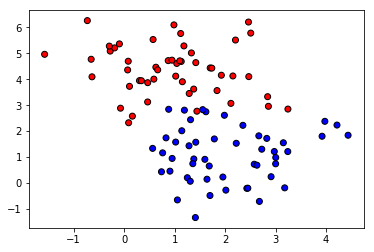

In [163]:
dibuja_dataset(dataset_X, dataset_y)

Para contar cuantos elmeentos hay de cada clase existe una función parecida a `value_counts` de pandas para numpy. Se llama `bincount`:

In [164]:
np.bincount(dataset_y)

array([50, 50], dtype=int64)

In [165]:
pd.Series(dataset_y).value_counts()

1    50
0    50
dtype: int64

Como vemos en este problema existen 50 muestras de la clase 0 y 50 de la clase 1. Un dataset se denomina balanceado cuando la distribución entre las clases es similar.

### Preguntas 1

* ¿Piensas que la mayor parte de los datasets son balanceados o no balanceados?
* ¿Podrías enumerar algún ejemplo de dataset balanceado y no balanceado?

Para darle un poco más realismo a este ejemplo vamos a "desbalancear" este dataset. Vamos a hacer que las 15 primeras muestras de la clase 0 convertirlas en clase 1. De manera que tengamos un 65% de las instancias pertenecientes a la clase 0 y 35% a la clase 1.

In [166]:
convertidas = 0
for i in range(len(dataset_y)):
    if dataset_y[i] == 0:
        dataset_y[i] = 1
        convertidas += 1
        if convertidas == 15:
            break

In [167]:
np.bincount(dataset_y)/len(dataset_y) # porcentajes

array([ 0.35,  0.65])

Podemos dibujar el dataset de nuevo y ver como han cambiado los datos:

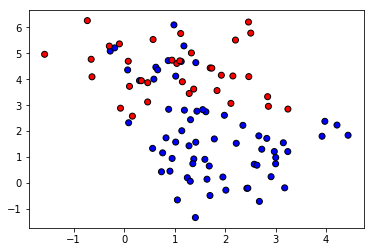

In [168]:
dibuja_dataset(dataset_X, dataset_y)

## Conjunto de entrenamiento y test

Como siempre separaremos los resultados en conjunto de entrenamiento y test

In [169]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=.3, random_state=42)

Dibujamos el conjunto de entrenamiento

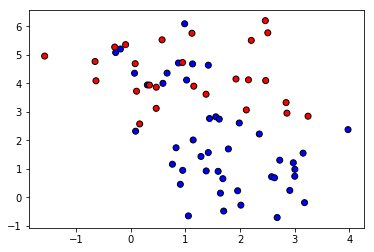

In [170]:
dibuja_dataset(X_train, y_train)

In [171]:
np.bincount(y_train)/len(y_train)

array([ 0.37142857,  0.62857143])

Y el de test:

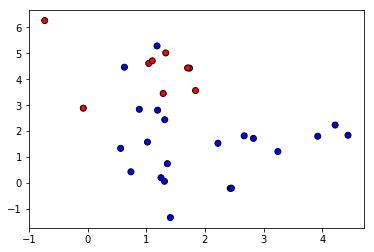

In [172]:
dibuja_dataset(X_test, y_test)

In [173]:
np.bincount(y_test)/len(y_test)

array([ 0.3,  0.7])

### Hagamos el conjunto aun mas desbalanceado

In [174]:
dataset_y2 = np.copy(dataset[1])

In [175]:
convertidas = 0
for i in range(len(dataset_y2)):
    if dataset_y2[i] == 0:
        dataset_y2[i] = 1
        convertidas += 1
        if convertidas == 40:
            break

In [176]:
np.bincount(dataset_y2)/len(dataset_y2)

array([ 0.1,  0.9])

####  Hagamos de nuevo la participacion Entrenamiento/Test

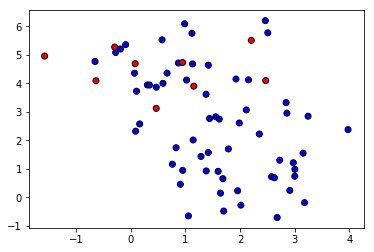

In [177]:
X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y2, test_size=.3, random_state=42)
dibuja_dataset(X_train, y_train)

In [178]:
np.bincount(y_train)/len(y_train)

array([ 0.12857143,  0.87142857])

Y el de test:

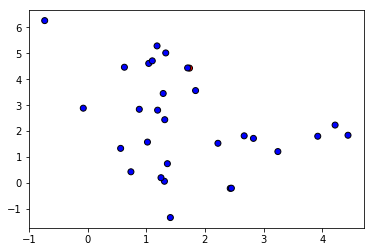

In [179]:
dibuja_dataset(X_test, y_test)

In [180]:
np.bincount(y_test)

array([ 1, 29], dtype=int64)

In [181]:
np.bincount(y_test)/len(y_test)

array([ 0.03333333,  0.96666667])

### Preguntas 3

* ¿Le ves algún problema a la división que hemos hecho a la clase de entrenamiento y test?
* Qué pasaria si diera la casualidad que al hacer el particionamiento entre entrenamiento y test, ¿sólo cayeran los elementos de una clase en un conjunto?
* ¿Estamos seguros de que el criterio de que el particionamiento de entrenamiento y test es el más adecuado?

##### Prueba con este nuevo código

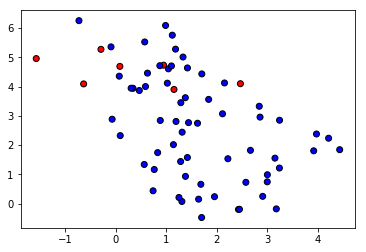

In [308]:
X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y2, test_size=.3, random_state=42, stratify=dataset_y2)
dibuja_dataset(X_train, y_train)

In [188]:
np.bincount(y_train)/len(y_train)

array([ 0.1,  0.9])

Y el de test:

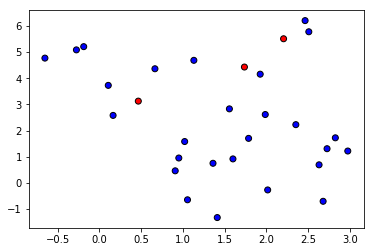

In [189]:
dibuja_dataset(X_test, y_test)

In [190]:
np.bincount(y_test)

array([ 3, 27], dtype=int64)

In [191]:
np.bincount(y_test)/len(y_test)

array([ 0.1,  0.9])

### Preguntas 3a

* ¿Que hemos cambiado en el codigo?
* ¿Hemos logrado ahora mantener las proporciones de las etiquetas en las dos particiones (Train/Test)?
* ¿Que crees que es la partición estratificada?

## Validación cruzada

Para resolver los problemas anteriores existe un método más robusto para hacer la división del conjunto de entrenamiento y test denominado validación cruzada. Este método consiste en repetir $n$ veces la división del conjunto de entrenamiento y test de manera que entrenemos y evaluemos con todos los datos.

<img src="cross_validation.png" width="80%">

El resultado con validación cruzada no es un único resultado, sino tantos como las iteraciones. Generalmente se suelen integrar los resultados usando la media aritmética.

Podemos utilizar validación cruzada con `sklearn` con la función `cross_val_score`:

#### Recuperamos un dataset no tan desbalanceado

In [192]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(LogisticRegression(), dataset_X, dataset_y, cv=5)

In [193]:
print(scores)

[ 0.65  0.6   0.75  0.9   0.9 ]


In [194]:
scores.mean()

0.76000000000000001

Un parámetro interesante de este método es `scoring` que nos permite que este método nos devuelva en vez de el porcentaje de acierto (`accuracy`) otras métricas.

Las métricas disponibles son:

`['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']`

In [195]:
cross_val_score(LogisticRegression(), dataset_X, dataset_y, scoring='precision')

array([ 0.86666667,  0.7826087 ,  0.84      ])

In [196]:
cross_val_score(LogisticRegression(), dataset_X, dataset_y, scoring='recall')

array([ 0.59090909,  0.81818182,  1.        ])

También existe otro parámetro interesante que es `cv` que nos permite configurar el número de particiones a realizar en la validación cruzada:

In [197]:
cross_val_score(LogisticRegression(), dataset_X, dataset_y, cv=10)

array([ 0.63636364,  0.63636364,  0.72727273,  0.54545455,  0.72727273,
        0.77777778,  1.        ,  1.        ,  0.88888889,  0.88888889])

## Clasificadores dummy
Una manera de entender como funcionan los clasificadores por dentro es utilizar clasificadores ficticios que nos ayuden a comprender mejor las métricas de evaluación y como evaluar los datasets.

En `sklearn` existe la clase `DummyClassifier` que nos permite instanciar un clasificador de este tipo. El parámetro más importante que recibe en su construcción es la estrategia de clasificación (`strategy`).

### Clase más frecuente

Podemos utilizar `most_frequent` para crear un clasificador que devuelva como clase predicha siempre la clase más frecuente: 

In [257]:
# Recuperamos la partición inicial Train/Test
X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=.3, random_state=42)

In [258]:
from sklearn.dummy import DummyClassifier

dc_most_frequent = DummyClassifier(strategy='most_frequent', random_state=None)

In [259]:
dc_most_frequent.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [263]:
# Las salidas coinciden siempre con la clase mas frecuente

y_test_hat = dc_most_frequent.predict(X_test)
print(y_test_hat)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Una vez entrenado podemos ver su % de acierto:

In [264]:
print(dc_most_frequent.score(X_test, y_test))

0.7


Que logicamente coincide con el valor esperado. Ya que este clasificador toma como clase predicha la clase más frecuente del conjunto de entrenamiento, que es la clase $1$.

Con este criterio clasifica el conjunto de test.

In [265]:
np.bincount(y_test)

array([ 9, 21], dtype=int64)

In [266]:
21 / (9 + 21)

0.7

Podemos verlo más claramente en la matriz de confusión:

In [267]:
y_predicted = dc_most_frequent.predict(X_test)

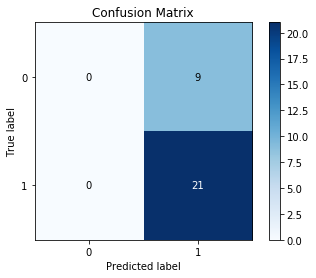

In [268]:
skplt.metrics.plot_confusion_matrix(y_test, y_predicted)

### Siguiendo las proporciones de los datos

Otro criterio para clasificar es devolver siempre un resultado aleatorio siguiendo la distribución de probabilidad de los datos.

In [285]:
dc_stratified = DummyClassifier(strategy='stratified', random_state=None)

In [286]:
np.bincount(dataset_y)/len(dataset_y) # distribucion etiquetas de la poblacion

array([ 0.35,  0.65])

In [287]:
np.bincount(y_train)/len(y_train)# distribucion etiquetas del conjunto de entrenamiento

array([ 0.37142857,  0.62857143])

In [288]:
dc_stratified.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [298]:
# Ejecuta varias veces este segmento de codigo. 
# Veras como las salidas varian aleatoriamente pero intentando mantener las proporciones de las etiquetas (no siempre bien!!)

y_test_hat = dc_stratified.predict(X_test)
print(y_test_hat)
print(np.mean(y_test_hat))

[1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0]
0.633333333333


In [299]:
print(dc_stratified.score(X_test, y_test))

0.6


En este caso, podemos interpretar el resultado de la siguiente manera: el clasificador habrá clasificado el 60% de las instancias de cada clase bien.

Pero deberia ser 65% que es la proporcion de las clases.

En este caso, existe una variación porque estamos utilizando números aleatorios sobre una población pequeña. El conjunto de entrenamiento contiene sólo 30 instancias.

In [300]:
y_predicted = dc_stratified.predict(X_test)

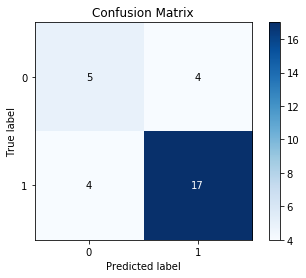

In [301]:
skplt.metrics.plot_confusion_matrix(y_test, y_predicted)

### Preguntas 4

* ¿Es el porcentaje de acierto una buena medida en conjuntos de datos no balanceados?
* Viendo los resultados obtenidos, ¿qué podríamos decir de un clasificador que tiene un % de acierto del 75%? ¿Y del 80%? ¿y del 90%?

## K-NN

En esta seguna parte del worksheet vamos a aprender una algoritmo de clasificación muy común que se llama `k-nearest-neighbour`, o en castellano `k-vecinos-más-próximo`.

El algoritmo parte de una idea muy sencilla. Supongamos que tenemos un dataset formado por dos clases, círculos azules y triángulos rojos. Si queremos clasificar una nueva instancia, un criterio fácil de clasificación podría ser, comparar esa instancia con todas las instancias del conjunto de entrenamiento y quedarnos con la clase de la más cercana.

<img src="knn_intro.png">

Eso es a lo que se denomina un modelo `knn` con $n=1$.

Este criterio lo podríamos mejorar, si en vez de quedarnos con el vecino más cercano nos quedamos con un conjunto $n$ de ellos y para determinar la clase resultado cogemos la clase más frecuente entre los vecinos.

Por ejemplo, en la siguiente figura:

<img src="knn.jpg">

Si escogemos:

* $k=1$ La instancia más cercana es una bola roja, luego la clase predicha sería rojo.
* $k=3$ Las instancias más cercanas son rojo, verde, rojo. Luego la clase predicha sería rojo.
* $k=5$ Las instancias más cercanas son rojo, verde, rojo, verde, verde. Luego la clase predicha sería verde.

Vamos a utilizarlo con `sklearn`:

In [302]:
from sklearn.neighbors import KNeighborsClassifier

In [303]:
nn_1 = KNeighborsClassifier(n_neighbors=1)

In [304]:
nn_1.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [305]:
print(nn_1.score(X_test, y_test))

0.8


In [307]:
np.bincount(y_test)/len(y_test)# distribucion etiquetas del conjunto de test

array([ 0.3,  0.7])

Podemos dibujar en este caso las líneas de separación sobre el conjunto de entrenamiento:

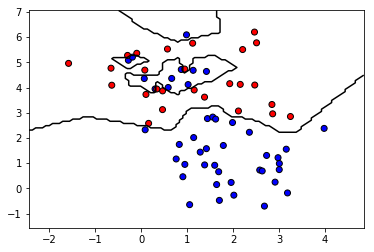

In [306]:
plot_2d_separator(nn_1, X_train, y_train)

podemos ir variando el parámetro $n$ para poder ir viendo los resultados:

In [141]:
def knn(n):
    nn = KNeighborsClassifier(n_neighbors=n)
    nn.fit(X_train, y_train) 
    plot_2d_separator(nn, X_train, y_train)

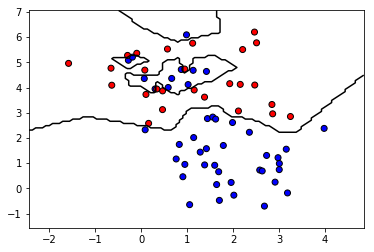

In [142]:
knn(1)

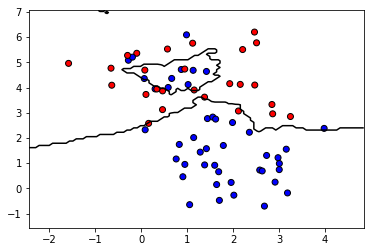

In [143]:
knn(5)

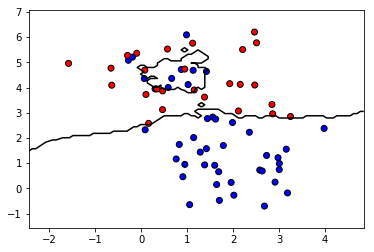

In [144]:
knn(10)

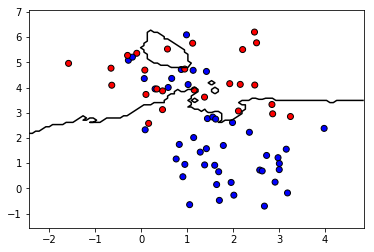

In [145]:
knn(20)

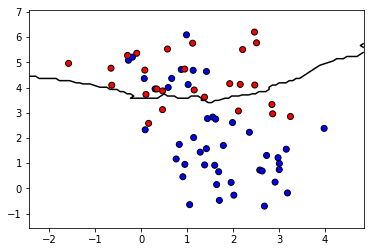

In [146]:
knn(40)

### Preguntas 5

* ¿Se te ocurre que aporta el parámetro $n$?
* ¿Qué pasa si $n$ es muy pequeño? ¿Y si $n$ es muy grande?
* ¿Qué ventajas e inconvenientes le ves a este algoritmo?